In [1]:
import gdown

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import tensorflow as tf
from typing import List
from matplotlib import pyplot as plt
import imageio
import numpy as np

In [4]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [5]:
model = tf.keras.models.load_model("/content/drive/MyDrive/lipnet01.h5", custom_objects={'CTCLoss': CTCLoss})

In [ ]:
model.summary()

In [ ]:
#'''ffmpeg -i C:\Users\Admin\Downloads\lipnet\test.mpg -vf "scale=360:288" -c:v mpeg2video -q:v 2 -an C:\Users\Admin\Downloads\lipnet\test01.mpg'''

In [14]:
mouthxml = '/content/drive/MyDrive/haarcascade_mcs_mouth.xml'
mouth_cascade = cv2.CascadeClassifier(mouthxml)

In [39]:
mouth_cascade.empty()

False

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    ds_factor = 0.5
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Ensure frames and mean are of the same data type (float32)
    frames = tf.cast(frames, tf.float32)
    mean = tf.cast(mean, tf.float32)

    # Perform the subtraction and division
    frames = (frames - mean) / std
    return frames

In [ ]:
#tf.convert_to_tensor('/content/drive/MyDrive/test.mpg')

In [64]:
ds_factor = 0.5
cap = cv2.VideoCapture('/content/drive/MyDrive/test07.mp4')
frames = []

while True:
    ret, frame = cap.read()

    if not ret:
        break

    frame = cv2.resize(frame, None, fx=ds_factor, fy=ds_factor, interpolation=cv2.INTER_AREA)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    mouth_rects = mouth_cascade.detectMultiScale(frame, 1.7, 11)
    for x, y, w, h in mouth_rects:
        y = int(y - 0.15 * h)
        mouth_roi = tf.image.rgb_to_grayscale(frame[y:y+h, x:x+w])
        frames.append(mouth_roi)

cap.release()

# Convert the list of NumPy arrays to a NumPy array
frames_np = np.array(frames)

# Calculate mean and standard deviation
mean = np.mean(frames_np)
std = np.std(frames_np)

result = (frames_np - mean) / std

result = tf.convert_to_tensor(result, dtype=tf.float32)

In [65]:
mouth_rects

array([[275, 206,  72,  43]], dtype=int32)

In [78]:
result.shape

TensorShape([149, 43, 72, 1])

In [ ]:
for x in range(len(result)):
  plt.imshow(result[x])
  plt.show()

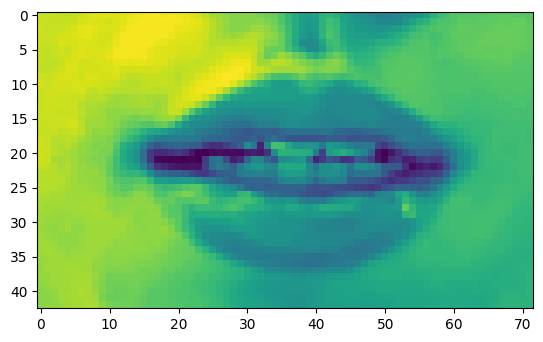

In [73]:
plt.imshow(result[120])
plt.show()

In [79]:
cap = cv2.VideoCapture('/content/drive/MyDrive/test07.mp4')
frames = []
for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[188:288,100:300])
cap.release()

frames = tf.convert_to_tensor(frames)
mean = tf.math.reduce_mean(frames)
std = tf.math.reduce_std(tf.cast(frames, tf.float32))

# Ensure frames and mean are of the same data type (float32)
frames = tf.cast(frames, tf.float32)
mean = tf.cast(mean, tf.float32)

# Perform the subtraction and division
result = tf.cast((frames - mean), tf.float32) / std



In [80]:
result.shape

TensorShape([118, 100, 200, 1])

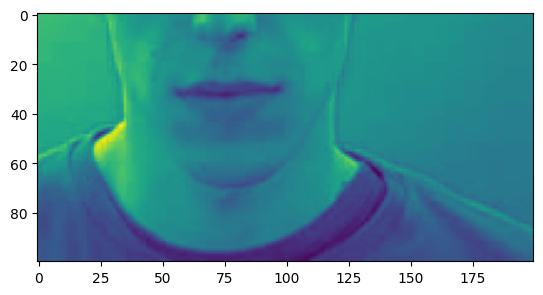

In [ ]:
plt.imshow(result[0])

In [ ]:
result_np = np.expand_dims(result, axis=0)

In [ ]:
result_np[0].shape

(75, 100, 200, 1)

In [ ]:
# Assuming result is a list of TensorFlow tensors
result_np_list = [frame.numpy() for frame in result]

# Convert to NumPy arrays and squeeze the last dimension
result_np_list = [np.squeeze(frame, axis=-1) for frame in result_np_list]

# Save the list of NumPy arrays as a GIF
imageio.mimsave('/content/drive/MyDrive/example.gif', result_np_list, fps=10)

In [ ]:
model.input_shape

(None, None, 100, 200, 1)

In [ ]:
result_np.shape

(1, 75, 100, 200, 1)

In [ ]:
pred = model.predict(result_np)

1/1 [==============================] - 22s 22s/step


In [ ]:
pred

array([[[5.6399031e-06, 4.1223058e-05, 9.8138237e-01, ...,
         1.9978379e-09, 7.9049940e-05, 2.9324478e-05],
        [6.8947993e-06, 1.1212924e-03, 1.1871307e-03, ...,
         2.5297775e-10, 2.0772237e-05, 2.8801069e-04],
        [1.6398542e-05, 5.9213131e-03, 1.1815821e-05, ...,
         1.4286831e-10, 3.1847320e-04, 1.4597586e-04],
        ...,
        [9.9546790e-01, 1.3108882e-08, 1.4546455e-08, ...,
         3.4364207e-09, 1.8437753e-08, 4.5232638e-03],
        [6.1833453e-03, 5.3259829e-08, 1.1689817e-08, ...,
         3.1581204e-10, 1.0279013e-07, 9.9378395e-01],
        [9.8773497e-01, 2.1772378e-07, 8.3575124e-08, ...,
         2.8568406e-08, 1.7582325e-07, 1.2214044e-02]]], dtype=float32)

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(pred[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin   greeen  ith      tihhh      looo'>